In [1]:
import hoomd
import hoomd.md
import fresnel
import gsd
import gsd.fl
import gsd.hoomd
import numpy

# temporary - eventually this helper will be part of Fresnel
import PIL.Image
import io
import IPython.display
def showarray(a, fmt='png'):
    f = io.BytesIO()
    PIL.Image.fromarray(a, mode='RGBA').save(f, fmt)
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))


HOOMD-blue v2.1.1-61-g8701fb2 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 12/07/2016
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----


# Fresnel

[Fresnel](https://bitbucket.org/glotzer/fresnel) is a new visualization tool designed to raytrace the output of HOOMD simulations. At the time of writing this tutorial (Dec 2016), Frensel is in the early development stages. These examples will use Fresnel to render example output.

Fresnel scenes consist of a number of primitives, where each primitive describes N shapes with similar properties. There is no direct translation from hoomd output to a Fresnel scene: you as the user must decide what primitive you wish to represent your data with.

## Disks in 2D

Let's use a simplified version of the quick start script to generate some 2D simulation data. This example logs the trajectory to a GSD file, then opens it for visualization. This simulates a batch computing environment on a cluster where you would run the simulation on the cluster and the visualization on your local workstation.

In [2]:
hoomd.context.initialize('--mode=cpu --notice-level=1')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=2.0), n=5)
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=3.0, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
all = hoomd.group.all();
hoomd.md.integrate.mode_standard(dt=0.001)
hoomd.md.integrate.langevin(group=all, kT=1.0, seed=987)
d = hoomd.dump.gsd("trajectory-2d-disk.gsd", period=100, group=all, overwrite=True)
hoomd.run(1000, quiet=True)

HOOMD-blue is running on the CPU


Now, read in the trajectory.

In [3]:
f = gsd.fl.GSDFile('trajectory-2d-disk.gsd', 'rb')
t = gsd.hoomd.HOOMDTrajectory(f)

For more details on how to configure and render a Fresnel scene, see the Fresnel documenation and examples. Here is a short example of how to render disks in 2D using the sphere primitive and an overhead camera.

Error importing: cannot import name '_gpu'


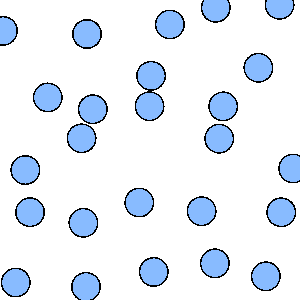

In [4]:
device = fresnel.Device()
scene = fresnel.Scene(device)
g = fresnel.geometry.Sphere(scene, position=t[-1].particles.position, radius=numpy.ones(t[-1].particles.N)*0.5)
g.material = fresnel.material.Material(solid=1.0, color=(0.25,0.5,1), geometry_color_mix=0.0)
cam = fresnel.camera.Orthographic(position=(0, 0, 10), look_at=(0,0,0), up=(0,1,0), height=t[-1].configuration.box[1])
whitted = fresnel.tracer.Whitted(device, 300, 300)
whitted.set_camera(cam)
a = whitted.render(scene)
showarray(a)

## 2D Polygons

The simulation we executed is of point particles, not polygons - but we can render as polygons anyways. Seeing the particle shape is important when analyzing HPMC and DEM simulations.

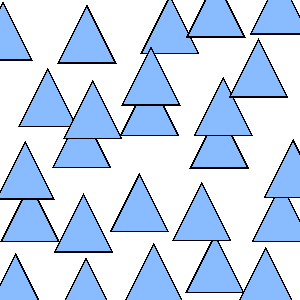

In [5]:
scene = fresnel.Scene(device)
g = fresnel.geometry.Prism(scene, [[-1, -1], [1, -1], [0,1]], position=t[-1].particles.position[:,0:2], height=numpy.ones(t[-1].particles.N))
g.material = fresnel.material.Material(solid=1.0, color=(0.25,0.5,1), geometry_color_mix=0.0)
cam = fresnel.camera.Orthographic(position=(0, 0, 10), look_at=(0,0,0), up=(0,1,0), height=t[-1].configuration.box[1])
whitted = fresnel.tracer.Whitted(device, 300, 300)
whitted.set_camera(cam)
a = whitted.render(scene)
showarray(a)

## Spheres in 3D

Again, the simulation was of point particles in 2D, but we can render in 3D anyways.

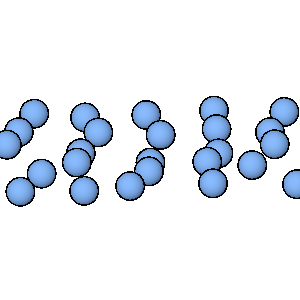

In [6]:
scene = fresnel.Scene(device)
g = fresnel.geometry.Sphere(scene, position=t[-1].particles.position, radius=numpy.ones(t[-1].particles.N)*0.5)
g.material = fresnel.material.Material(solid=0.0, color=(0.25,0.5,1), geometry_color_mix=0.0)
cam = fresnel.camera.Orthographic(position=(0, 10, 3), look_at=(0,0,0), up=(0,0,1), height=t[-1].configuration.box[1])
whitted = fresnel.tracer.Whitted(device, 300, 300)
whitted.set_camera(cam)
a = whitted.render(scene)
showarray(a)

## Helper functions

The above examples show how to use Frensel explicitly. Other examples in this repository will use one-liner helper functions to render output from the examples. See the code in [ex_render.py](ex_render.py). Let's use it to render the disk image with one line.

Error importing: cannot import name '_gpu'


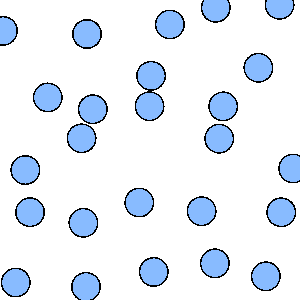

In [7]:
import ex_render
showarray(ex_render.render_disks('trajectory-2d-disk.gsd'))

We can even make animated GIF movies (see [ex_render.py](ex_render.py) for the implementation.

Size: 173.2685546875 KiB


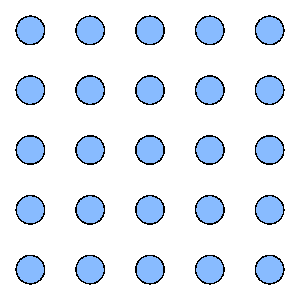

In [8]:
ex_render.display_movie(ex_render.render_disk_frame, 'trajectory-2d-disk.gsd')